<a href="https://colab.research.google.com/github/Hadrien-Cornier/pyvaluation/blob/main/financial_betas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance matplotlib -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 695 kB/s 
     |████████████████████████████████| 6.4 MB 11.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import pandas as pd
# Import yfinance and matplotlib
import yfinance as yf  
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

In [140]:
def get_weekly_returns_of_asset(asset, num_years=3):
    today = datetime.date.today()
    past = today - datetime.timedelta(days=365*num_years)
    asset_df=yf.download(asset,past,today)
    # adjusted close corrects for splits and dividends
    acp = adjusted_close_price = asset_df.join(pd.DataFrame(yf.Ticker(asset).dividends), on="Date", how="left")
    # adjusted close
    acp = acp[acp.columns[acp.columns.isin(['Date', 'Adj Close', 'Dividends'])]]
    # replace NaN dividends with 0s
    acp=acp.fillna(axis=1,value=0)
    acp=acp.reset_index()
    acp['yearmonthweek']=pd.to_datetime(acp['Date']).map(lambda x:str(x.year) + "|" + ('0'+str(x.month))[-2:] + "|" + ('0'+str(x.week))[-2:])
    acp[asset] = acp['Adj Close'] + acp['Dividends']
    pre_returns=acp[[asset,'yearmonthweek']].groupby(by=['yearmonthweek']).mean().reset_index().sort_values(by='yearmonthweek',ascending='True')
    market_returns = pre_returns[asset].pct_change().fillna(0)
    return market_returns

In [162]:
def beta(asset_ticker, market_ticker='SPY'):
    """
    this is the beta from the CAPM model that assumes that stock returns are :
    Ra-Rf = + Beta * (Rm-Rf)
    Ra = Rf(1-Beta) + Beta*Rm

    Where 
    Rf is the riskfree rate
    Rm is the market return
    Ra is the return of the asset

    TODO : COmpute Jensen's Alpha
    """
    market = get_weekly_returns_of_asset(market_ticker)
    asset_ticker = asset_ticker
    asset_to_compare = get_weekly_returns_of_asset(asset_ticker)
    beta_df= pd.DataFrame(market).join(pd.DataFrame(asset_to_compare))
    mlr = smf.ols(formula=f"{asset_ticker} ~ {market_ticker}", data=beta_df).fit()
    print(mlr.summary())
    X_plot = beta_df[market_ticker]
    Y_plot = mlr.fittedvalues
    g = sns.FacetGrid(beta_df, size = 6)
    g = g.map(plt.scatter, market_ticker, asset_ticker, edgecolor="w")
    plt.plot(X_plot, Y_plot, color='r')
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     269.0
Date:                Sat, 28 May 2022   Prob (F-statistic):           4.47e-37
Time:                        05:42:58   Log-Likelihood:                 458.92
No. Observations:                 175   AIC:                            -913.8
Df Residuals:                     173   BIC:                            -907.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


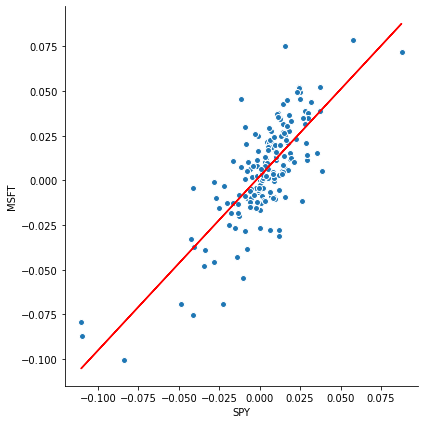

In [163]:
beta('MSFT')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     213.4
Date:                Sat, 28 May 2022   Prob (F-statistic):           5.22e-32
Time:                        05:43:04   Log-Likelihood:                 411.97
No. Observations:                 175   AIC:                            -819.9
Df Residuals:                     173   BIC:                            -813.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


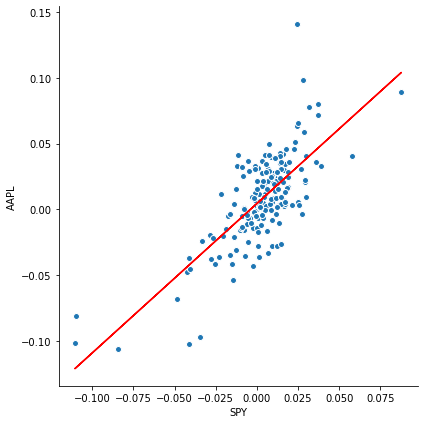

In [164]:
beta('AAPL')